# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import imageio

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

import matplotlib.pyplot as plt
%matplotlib inline

# 2. Load data

In [2]:
image_path = '../data/people_segmentation/images'
mask_path = '../data/people_segmentation/masks'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + "/" + i for i in image_list]
mask_list = [mask_path + "/" + i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

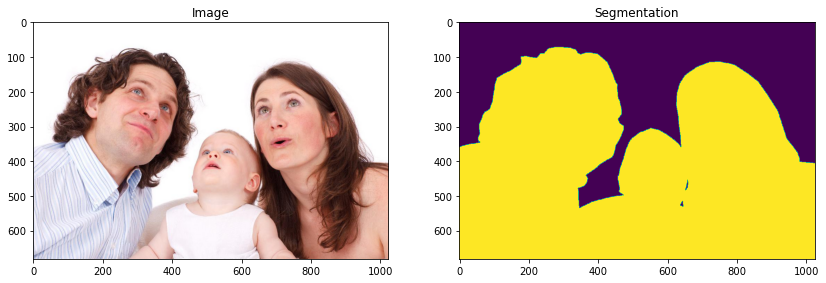

In [3]:
N = 13
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

## Split data into masked and unmasked images

In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)